In [1]:
!pip install -U datasets -q

In [2]:
!pip install -q huggingface_hub

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import (
    AutoTokenizer,
    AutoConfig,
    AutoModelForSequenceClassification,
    get_linear_schedule_with_warmup
)
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
from dataclasses import dataclass
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from huggingface_hub import notebook_login
notebook_login()

In [5]:
MODEL_NAME      = "bert-base-uncased"
NUM_LABELS      = 4
BATCH_SIZE      = 16
LR              = 3e-5
EPOCHS          = 3
ALPHA           = 0.5
TEMPERATURE     = 2.0
STUDENT_HIDDEN  = 256
STUDENT_LAYERS  = 4
STUDENT_HEADS   = 4
STUDENT_INTER   = 512
MAX_LEN         = 128

In [6]:
def prepare_data(batch_size=BATCH_SIZE):
    dataset = load_dataset("wangrongsheng/ag_news")

    def tokenize(batch):
        return tokenizer(batch["text"],
                         padding="max_length",
                         truncation=True,
                         max_length=MAX_LEN,
                         return_tensors="pt")

    encoded = dataset.map(tokenize, batched=True, batch_size=batch_size)
    encoded = encoded.remove_columns(["text"])
    encoded = encoded.rename_column("label", "labels")
    encoded.set_format("torch")

    train_loader = DataLoader(encoded["train"], batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(encoded["test"],  batch_size=batch_size)
    return train_loader, val_loader


In [7]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
teacher = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=NUM_LABELS).to(device)
teacher.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [8]:
@dataclass
class TransformerConfig:
    vocab_size: int
    hidden_size: int = STUDENT_HIDDEN
    num_heads: int = STUDENT_HEADS
    intermediate_size: int = STUDENT_INTER
    num_layers: int = STUDENT_LAYERS
    max_position_embeddings: int = MAX_LEN
    dropout: float = 0.1
    num_labels: int = NUM_LABELS

In [9]:
class TransformerBlock(nn.Module):
    def __init__(self, cfg: TransformerConfig):
        super().__init__()
        self.attn = nn.MultiheadAttention(
            embed_dim=cfg.hidden_size,
            num_heads=cfg.num_heads,
            dropout=cfg.dropout,
            batch_first=True
        )
        self.norm1 = nn.LayerNorm(cfg.hidden_size)
        self.ff = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.intermediate_size),
            nn.GELU(),
            nn.Linear(cfg.intermediate_size, cfg.hidden_size),
        )
        self.norm2 = nn.LayerNorm(cfg.hidden_size)
        self.dropout = nn.Dropout(cfg.dropout)

    def forward(self, x, mask=None):
        attn_out, _ = self.attn(x, x, x, key_padding_mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)
        ff_out = self.ff(x)
        x = x + self.dropout(ff_out)
        x = self.norm2(x)
        return x

class TransformerStudent(nn.Module):
    def __init__(self, cfg: TransformerConfig, teacher_emb):
        super().__init__()
        self.embeddings = teacher_emb
        self.embed_proj = nn.Linear(
            teacher_emb.word_embeddings.embedding_dim,
            cfg.hidden_size
        )
        self.pos_ids = torch.arange(cfg.max_position_embeddings).unsqueeze(0)
        self.layers = nn.ModuleList([
            TransformerBlock(cfg) for _ in range(cfg.num_layers)
        ])
        self.pooler     = nn.Linear(cfg.hidden_size, cfg.hidden_size)
        self.activation = nn.Tanh()
        self.dropout    = nn.Dropout(cfg.dropout)
        self.classifier = nn.Linear(cfg.hidden_size, cfg.num_labels)

    def forward(self, input_ids, attention_mask):
        emb_768 = self.embeddings(
            input_ids=input_ids,
            position_ids=self.pos_ids[:, :input_ids.size(1)].to(input_ids.device)
        )
        x = self.embed_proj(emb_768)

        pad_mask = attention_mask == 0

        for layer in self.layers:
            x = layer(x, mask=pad_mask)

        cls_tok = x[:, 0]
        pooled  = self.pooler(cls_tok)
        pooled  = self.activation(pooled)
        pooled  = self.dropout(pooled)
        logits  = self.classifier(pooled)
        return logits

In [10]:
cfg     = TransformerConfig(vocab_size=tokenizer.vocab_size)
student = TransformerStudent(cfg, teacher.bert.embeddings).to(device)
optimizer = AdamW(student.parameters(), lr=LR)

In [11]:
def distill_loss(student_logits, teacher_logits, labels):
    loss_ce = F.cross_entropy(student_logits, labels)
    loss_kd = F.kl_div(
        F.log_softmax(student_logits / TEMPERATURE, dim=-1),
        F.softmax(teacher_logits / TEMPERATURE, dim=-1),
        reduction='batchmean'
    ) * (TEMPERATURE ** 2)
    return ALPHA * loss_ce + (1 - ALPHA) * loss_kd

In [12]:
train_loader, val_loader = prepare_data()
for epoch in range(EPOCHS):
    student.train()
    total_loss = 0
    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        input_ids      = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels         = batch["labels"].to(device)

        with torch.no_grad():
            t_logits = teacher(input_ids, attention_mask=attention_mask).logits

        s_logits = student(input_ids, attention_mask)

        loss = distill_loss(s_logits, t_logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch+1} — Avg Loss: {avg_loss:.4f}")

Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

Epoch 1/3: 100%|██████████| 7500/7500 [18:03<00:00,  6.92it/s]


Epoch 1 — Avg Loss: 0.4484


Epoch 2/3: 100%|██████████| 7500/7500 [18:00<00:00,  6.94it/s]


Epoch 2 — Avg Loss: 0.4247


Epoch 3/3: 100%|██████████| 7500/7500 [18:01<00:00,  6.94it/s]

Epoch 3 — Avg Loss: 0.4157


In [13]:
student.eval()
correct = total = 0
with torch.no_grad():
    for batch in val_loader:
        in_ids = batch["input_ids"].to(device)
        am     = batch["attention_mask"].to(device)
        lbls   = batch["labels"].to(device)
        preds = student(in_ids, am).argmax(dim=1)
        correct += (preds == lbls).sum().item()
        total   += lbls.size(0)

In [14]:
torch.save(student.state_dict(), "transformer_student.pt")
tokenizer.save_pretrained("transformer_student")

('transformer_student/tokenizer_config.json',
 'transformer_student/special_tokens_map.json',
 'transformer_student/vocab.txt',
 'transformer_student/added_tokens.json',
 'transformer_student/tokenizer.json')

In [15]:
final_accuracy = correct / total
print(f"Final Test Accuracy: {final_accuracy:.4%}")

Final Test Accuracy: 92.4868%


BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


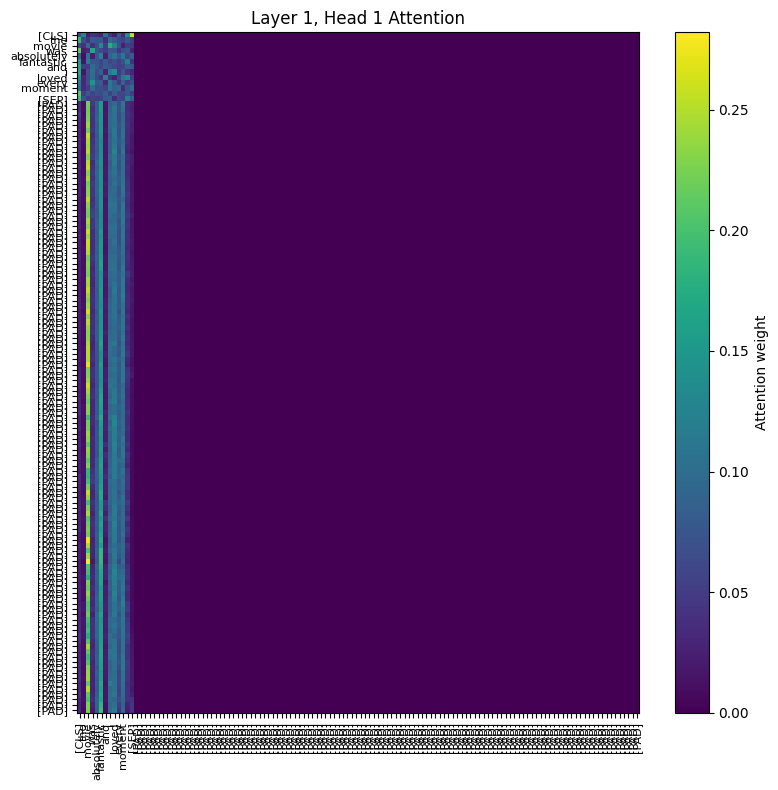

In [16]:
import matplotlib.pyplot as plt
import torch

teacher.config.output_attentions = True

sentence = "The movie was absolutely fantastic and I loved every moment."
inputs = tokenizer(sentence,
                   padding="max_length",
                   truncation=True,
                   max_length=MAX_LEN,
                   return_tensors="pt").to(device)

with torch.no_grad():
    outputs = teacher(**inputs)

attentions = outputs.attentions

layer_idx = 0
head_idx  = 0
attn = attentions[layer_idx][0, head_idx].cpu().numpy()

tokens = tokenizer.convert_ids_to_tokens(inputs["input_ids"][0])

plt.figure(figsize=(8, 8))
plt.imshow(attn, interpolation="nearest", aspect="auto")
plt.colorbar(label="Attention weight")
plt.xticks(range(len(tokens)), tokens, rotation=90, fontsize=8)
plt.yticks(range(len(tokens)), tokens, fontsize=8)
plt.title(f"Layer {layer_idx+1}, Head {head_idx+1} Attention")
plt.tight_layout()
plt.show()
